In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from sdebridge import diffusion_bridge as db
from sdebridge import sdes
from sdebridge.utils import score_fn, fourier_coefficients, inverse_fourier
from sdebridge.data_processing import sample_ellipse, butterfly1_pts, butterfly2_pts

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

In [3]:
T=1.
N=100
dim=2
num_bases = 5
sigma=0.05

bm_sde = sdes.brownian_sde(T, N, dim, 2*num_bases, sigma)

In [4]:
butterfly = jnp.array(butterfly1_pts())[:, ::1861][:, ::1].T
butterfly_coeffs = fourier_coefficients(butterfly, num_bases)

butterfly_recon = inverse_fourier(butterfly_coeffs, 120)
print(butterfly_recon.shape)
print(butterfly_coeffs.shape)

(120, 2)
(10, 2)


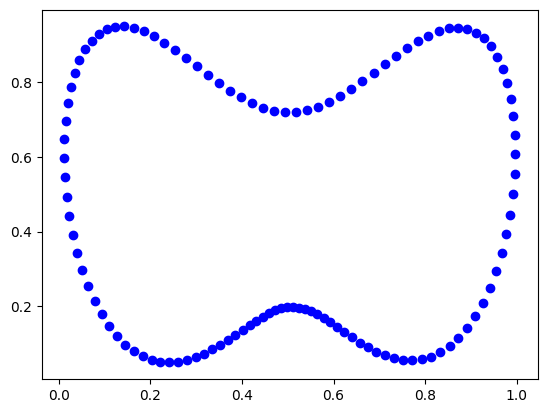

In [5]:
plt.scatter(butterfly_recon[:, 0], butterfly_recon[:, 1], c="b")

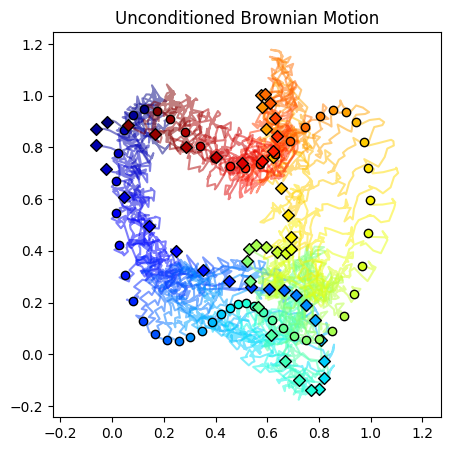

In [6]:
from sdebridge.plotting import plot_single_trajectory

key = jax.random.PRNGKey(2)
forward_trajs = sdes.simulate_traj(bm_sde, butterfly_coeffs, 2, key)

forward_traj_coeffs = forward_trajs[0]
forward_traj = inverse_fourier(forward_traj_coeffs, 50)
traj = forward_traj.reshape((N, -1))
plot_single_trajectory(traj, "Unconditioned Brownian Motion")


In [7]:
trace_bm_sde = sdes.trace_brownian_sde(T, N, dim, 2*num_bases, alpha=0.1, power=2)

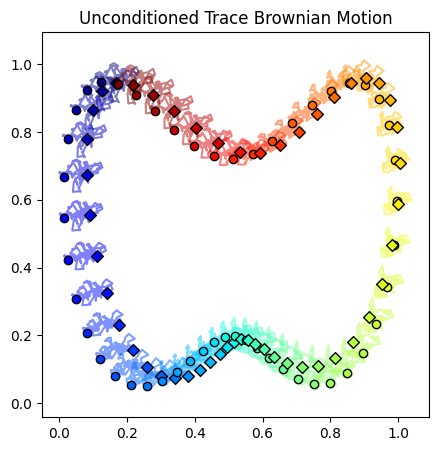

In [8]:
key = jax.random.PRNGKey(2)
forward_trajs_trace = sdes.simulate_traj(trace_bm_sde, butterfly_coeffs, 2, key)

forward_trace_coeffs = forward_trajs_trace[0]
forward_trace = inverse_fourier(forward_trace_coeffs, 50)
traj = forward_trace.reshape((N, -1))
plot_single_trajectory(traj, "Unconditioned Trace Brownian Motion")

In [9]:
from sdebridge.networks.score_unet import ScoreUNet

neural_net = ScoreUNet

network = {
    "output_dim": bm_sde.dim*bm_sde.n_bases,
    "time_embedding_dim": 32,
    "init_embedding_dim": 32,
    "act_fn": "silu",
    "encoder_layer_dims": [64, 32, 16, 8],
    "decoder_layer_dims": [8, 16, 32, 64],
    "batchnorm": True,
}

training = {
    "batch_size": 100,
    "load_size": 5000,
    "num_epochs": 100,
    "learning_rate": 5e-3,
    "warmup_steps": 0,
}


target = butterfly_coeffs
train_key = jax.random.split(key, 2)[0]
score_p_state = db.learn_p_score(bm_sde, target, train_key, **training, net=neural_net, network_params=network)

Training: 100%|██████████| 100/100 [06:42<00:00,  4.02s/epoch, Epoch=100, loss=9.3498]


In [10]:
initial_pts = jnp.array(butterfly2_pts())[:, ::475][:, ::1].T
initial_coeffs = fourier_coefficients(initial_pts, num_bases)


reverse_sde = sdes.reverse(bm_sde, score_fn(score_p_state))
backward_coeffs = sdes.simulate_traj(reverse_sde, initial_coeffs, 2, key)

forward_coeffs = sdes.simulate_traj(bm_sde, initial_coeffs, 2, key)


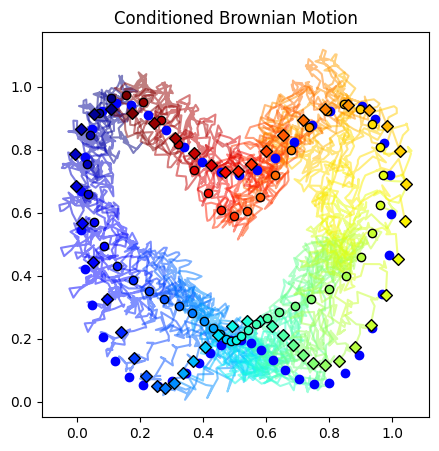

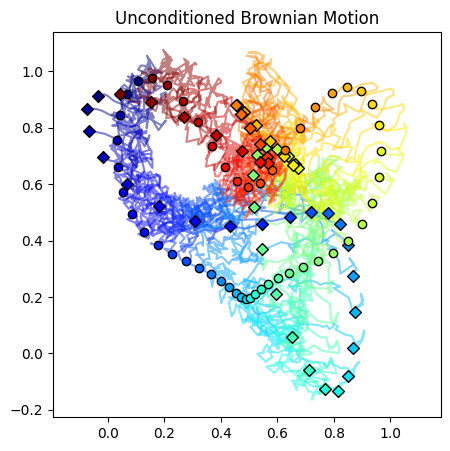

In [11]:
backward_traj = inverse_fourier(backward_coeffs[0], 50)
traj = backward_traj.reshape((N, -1))
plot_single_trajectory(traj, "Conditioned Brownian Motion")
target_plt = inverse_fourier(target, 50)
plt.scatter(target_plt[:, 0], target_plt[:, 1], c="b")

forward_traj = inverse_fourier(forward_coeffs[0], 50)
traj = forward_traj.reshape((N, -1))
plot_single_trajectory(traj, "Unconditioned Brownian Motion")


(2, 100, 10, 2)


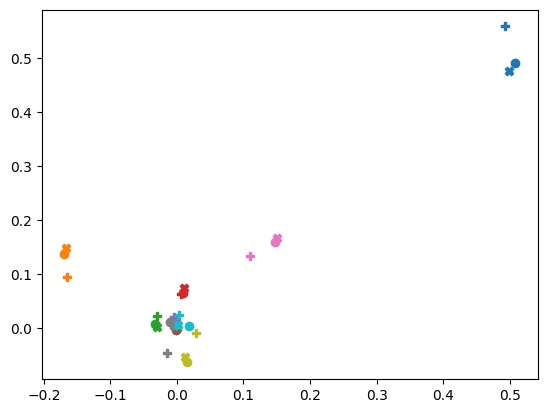

In [12]:
# plot target coefficients vs backward trajectory last coefficients

plt_backward_coeffs = backward_coeffs[0]
print(backward_coeffs.shape)

for i, coeff in enumerate(range(2*num_bases)):
    plt.scatter(plt_backward_coeffs[-1, coeff, 0], plt_backward_coeffs[-1, coeff, 1], color=f"C{i}")
    plt.scatter(plt_backward_coeffs[0, coeff, 0], plt_backward_coeffs[0, coeff, 1], color=f"C{i}", marker="P")
    # plt.plot(plt_backward_coeffs[:, coeff, 0], plt_backward_coeffs[:, coeff, 1], color=f"C{i}")
    plt.scatter(target[coeff, 0], target[coeff, 1], color=f"C{i}", marker="X")
